# Kanada’daki Evlerin Regresyon Modelleri Kullanılarak Tahmin Edilmesi
- Yazar: Bora Dere
- Son güncelleme: 10/02/2024
- İletişim: boradere@hotmail.com.tr

## 1- Veriyi İnceleme

### 1.1- Importlar ve Veri Setinin Yüklenmesi

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
sns.set_theme()

data = pd.read_csv('HouseListings-Top45Cities-10292023-kaggle.csv', encoding='latin1')

### 1.2- Verinin Genel Açıklaması

In [4]:
df = pd.DataFrame(data)
df

,City,Price,Address,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,Ontario,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,Ontario,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...,...
35763,Halifax,439900.0,301 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35764,Halifax,6990000.0,1160 Rockcliffe Street,5,5,Nova Scotia,431479,44.8857,63.1005,86753.0
35765,Halifax,419900.0,212 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35766,Halifax,949900.0,10 Idlewylde Road,3,1,Nova Scotia,431479,44.8857,63.1005,86753.0


<span style="color: red;">City:</span> İlanların bulunduğu şehir veya büyük metropol alanı. Örneğin, Toronto, Markham, Oakville gibi çevre banliyölerden ilanları içerebilir.

<span style="color: red;">Price:</span> Kanada doları cinsinden mülkün listelenen fiyatı.

<span style="color: red;">Address:</span> İlan için sokak adresi ve varsa daire numarası.

<span style="color: red;">Number_Beds:</span> İlanda belirtilen yatak odası sayısı.

<span style="color: red;">Number_Baths:</span> İlanda belirtilen banyo sayısı.

<span style="color: red;">Province:</span> Her şehrin bulunduğu il. Not: Ottawa gibi sınır şehirleri, Gatineau gibi sınırdışı şehirlerden ilan içermez.

<span style="color: red;">Population:</span> Şehir nüfusu. simplemaps'ten alınan verilere göre (https://simplemaps.com/data/canada-cities)

<span style="color: red;">Longitude / Latitude:</span> Şehirlerin boylam ve enlem verileri, simplemaps'ten alınmıştır (https://simplemaps.com/data/canada-cities)

<span style="color: red;">Median_Family_Income:</span> Şehir için 2021 Kanada nüfus sayımından alınan ortanca hane geliri.

In [5]:
df.isnull().sum()

City                    0
Price                   0
Address                 0
Number_Beds             0
Number_Baths            0
Province                0
Population              0
Latitude                0
Longitude               0
Median_Family_Income    0
dtype: int64

Herhangi bir null value görünmüyor, gayet güzel.

### 1.3- Dağılımların İncelenmesi

Dağılımları istendiği üzere histogramla incelemeye başlamadan önce Address kolonunu incelemeliyiz. Adres eşsiz bir veridir ve bu kadar büyük bir veri setinde eşsiz bir veriden çok sayıda farklı girdi olacağı için bu türde bir veriyi histogramla incelemek veya plotlamak imkansız olacaktır.

In [6]:
print(df['Address'].value_counts())

Address
#NAME?                              32
1475-1477-1479, rue Houle           12
5894 rue de la Seine                12
1014-1016-1018                      12
6980 rue de Honfleur                12
                                    ..
7944 REGENT Court                    1
2792 FIFTH ST LOUTH Street           1
6767 THOROLD STONE Road Unit# 94     1
17 Old Pine Trail                    1
208 2842-2856 Gottingen              1
Name: count, Length: 31379, dtype: int64


Görülebileceği üzere 31379 adet farklı girdi var, bunlardan en çok sayıda bulunansa "#NAME?", yani muhtemelen adresin bilinmediğini gösteren bir girdi. Bunu saymazsak en çok tekrar eden girdinin 12 adet olduğu gibi, 31379 farklı girdi tek başına bu kolonun dağılımını incelememizi zorlaştırıyor, hele histogram kullanarak. 

Şimdilik diğer kolonlara bakalım. Bin sayısını seçmek için Sturge'ün metodunu kullanacağız.

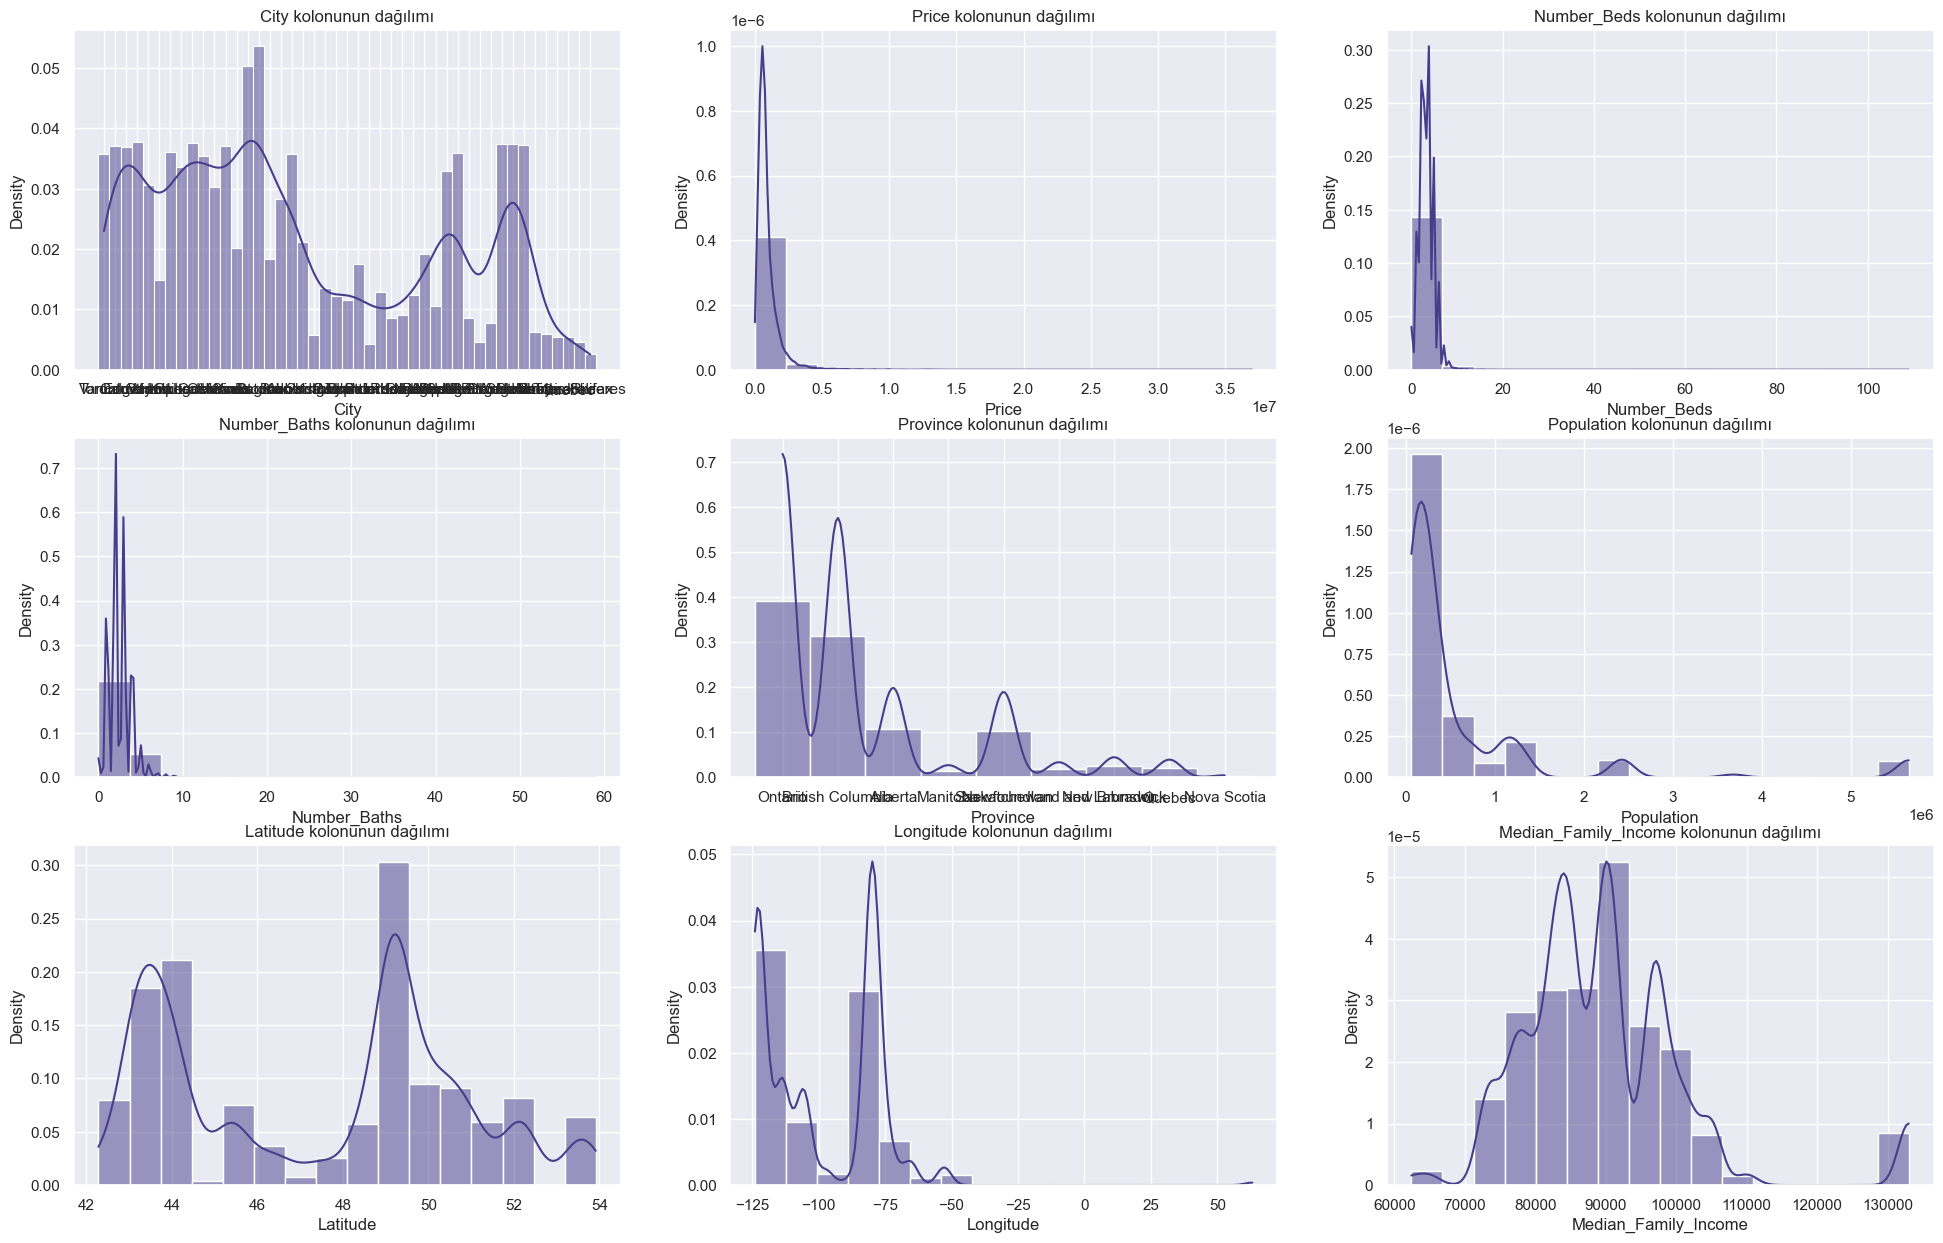

In [7]:
cols = [col for col in df.columns if col not in ['Address']]

plt.figure(figsize=(24, 15))

for i, col in enumerate(cols):
    # Sturge metodu
    bin_count = 1 + 3.3*math.log(len(data[col]), 10)
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, color='darkslateblue', stat='density', bins=int(bin_count))
    plt.title(f"{col} kolonunun dağılımı")

İki kolonun daha histogram ile düzgün ifade edilemeyeceği görülüyor. Onlar için farklı yollar deneyeceğiz. Mesela City:

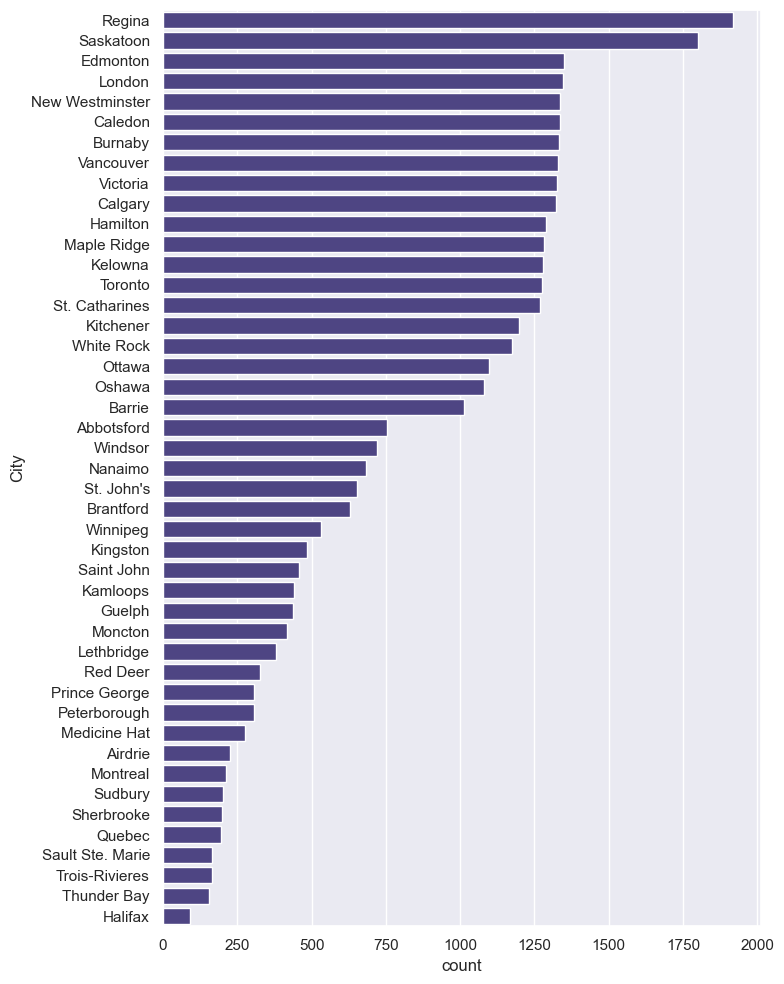

In [8]:
plt.figure(figsize=(8, 10))

sns.countplot(data=df, y='City', order=df['City'].value_counts().index, color='darkslateblue', saturation=.8)
plt.tight_layout()

Province kolonuna bakalım:

<AxesSubplot: xlabel='count', ylabel='Province'>

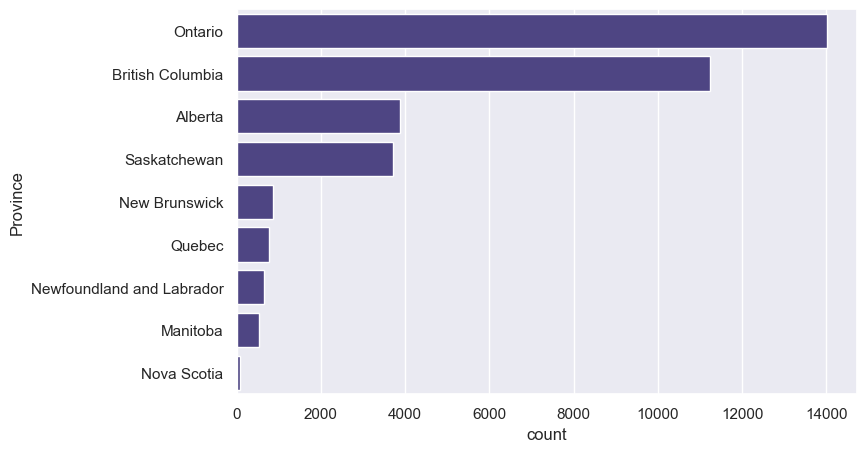

In [9]:
plt.figure(figsize=(8, 5))

sns.countplot(data=df, y='Province', order=df['Province'].value_counts().index, color='darkslateblue', saturation=.8)

Eksenleri değiştirip plotları ortak gridden çıkarmak bu iki kolonun dağılımını göstermek için işe yaramışa benziyor. Zira bu iki kolon numerik olmadığı için standart eksen düzeninde histogram ile görüntülenmeye pek uygun değil. Bu yöntemle teoride Address de plotlanabilir ancak orantısız sayıdaki eşsiz girdi yüzünden hem çok uzun sürecektir hem de incelenmesi pek de mümkün olmayan bir plot olacaktır.

### 1.4- Verinin Hazırlanması

Çıkarılması gereken kolonlara gelince, Address kesinlikle çıkarılmalıdır. Çünkü bu kadar fazla sayıda eşsiz değer içeren bir özelliğe encoding yapmak da, bu özelliği modele sokmak da kesinlikle verimsiz olacaktır. Bunun dışındaki kategorik özelliklere farklı yöntemler uygulanabilir.

In [10]:
df.drop(['Address'], inplace=True, axis=1)
df

,City,Price,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,3,2,Ontario,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,3,1,Ontario,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,2,2,Ontario,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,4,2,Ontario,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,1,1,Ontario,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
35763,Halifax,439900.0,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35764,Halifax,6990000.0,5,5,Nova Scotia,431479,44.8857,63.1005,86753.0
35765,Halifax,419900.0,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35766,Halifax,949900.0,3,1,Nova Scotia,431479,44.8857,63.1005,86753.0


City kolonuna gelince: 45 farklı şehir ismi olması one-hot encoding uygulamamızı engelliyor, çünkü uygulandığı takdirde verinin boyutu epeyce artacak, bu da bir dezavantaj olur. City kolonunu çıkarmak veya bu kolona başka bir encoding uygulamak seçeneklerimizin arasında. City kolonunun fiyat üzerinde doğrudan bir etkisi olup olmadığını bilmediğimiz için target encoding uyguluyoruz. 

In [12]:
mean = df.groupby('City')['Price'].mean()
df.loc[:, 'City'] = df['City'].map(mean)
df

,City,Price,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,1235288.773511,779900.0,3,2,Ontario,5647656,43.7417,-79.3733,97000.0
1,1235288.773511,799999.0,3,1,Ontario,5647656,43.7417,-79.3733,97000.0
2,1235288.773511,799900.0,2,2,Ontario,5647656,43.7417,-79.3733,97000.0
3,1235288.773511,1200000.0,4,2,Ontario,5647656,43.7417,-79.3733,97000.0
4,1235288.773511,668800.0,1,1,Ontario,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
35763,794771.087912,439900.0,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35764,794771.087912,6990000.0,5,5,Nova Scotia,431479,44.8857,63.1005,86753.0
35765,794771.087912,419900.0,2,2,Nova Scotia,431479,44.8857,63.1005,86753.0
35766,794771.087912,949900.0,3,1,Nova Scotia,431479,44.8857,63.1005,86753.0


One-hot encoding öncesi özellikler arası korelasyon kontrolü yapıyoruz. Diğer modeller için pek bir şey ifade etmek zorunda olmasa da Linear Regression doğrusal ilişkilere baktığı için korelasyonu yüksek özellikler kullanmak istiyoruz. Sadece bu kontrol için kullanılacak, başka bir görevi olmayan bir dummy data oluşturarak korelasyon matrixini inceleyeceğiz. 

In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dum = df.copy()
dum['Province'] = le.fit_transform(dum['Province'])
dum

,City,Price,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,1235288.773511,779900.0,3,2,6,5647656,43.7417,-79.3733,97000.0
1,1235288.773511,799999.0,3,1,6,5647656,43.7417,-79.3733,97000.0
2,1235288.773511,799900.0,2,2,6,5647656,43.7417,-79.3733,97000.0
3,1235288.773511,1200000.0,4,2,6,5647656,43.7417,-79.3733,97000.0
4,1235288.773511,668800.0,1,1,6,5647656,43.7417,-79.3733,97000.0
...,...,...,...,...,...,...,...,...,...
35763,794771.087912,439900.0,2,2,5,431479,44.8857,63.1005,86753.0
35764,794771.087912,6990000.0,5,5,5,431479,44.8857,63.1005,86753.0
35765,794771.087912,419900.0,2,2,5,431479,44.8857,63.1005,86753.0
35766,794771.087912,949900.0,3,1,5,431479,44.8857,63.1005,86753.0


<AxesSubplot: >

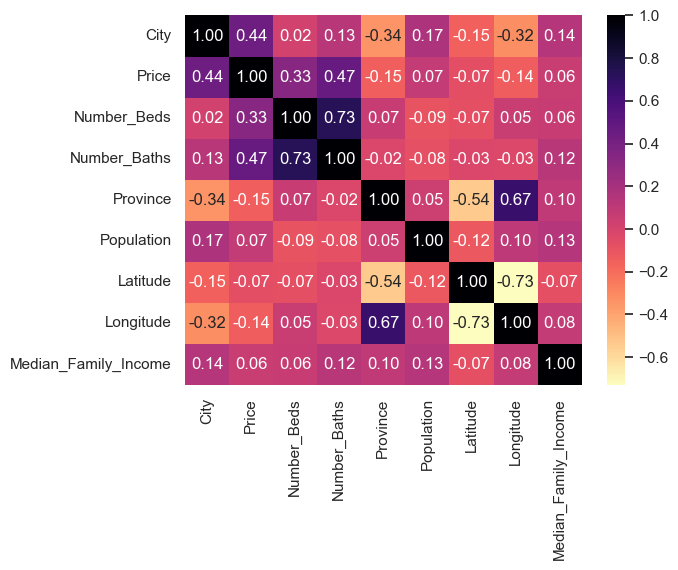

In [74]:
corr = dum.corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='magma_r')

Linear data için Number_Baths, Number_Beds ve City özelliklerini kullanacağız.

In [ ]:
df_linear = df.copy()
df_linear = df.loc[:, ['Number_Baths', 'Number_Beds', 'Price', 'City']]

df_linear

In [13]:
df_linear['City'] = df['City']
df_linear

,Number_Baths,Number_Beds,Price,City
0,2,3,779900.0,1235288.773511
1,1,3,799999.0,1235288.773511
2,2,2,799900.0,1235288.773511
3,2,4,1200000.0,1235288.773511
4,1,1,668800.0,1235288.773511
...,...,...,...,...
35763,2,2,439900.0,794771.087912
35764,5,5,6990000.0,794771.087912
35765,2,2,419900.0,794771.087912
35766,1,3,949900.0,794771.087912


Province kolonu ise City'ye nazaran daha az sayıda eşsiz girdiye sahip. Bu kolon için one-hot encoding uygulamak iyi bir seçenek olacaktır.

In [14]:
df_encoded = pd.get_dummies(df, columns=['Province'])
df_encoded

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
0,1235288.773511,779900.0,3,2,5647656,43.7417,-79.3733,97000.0,False,False,False,False,False,False,True,False,False
1,1235288.773511,799999.0,3,1,5647656,43.7417,-79.3733,97000.0,False,False,False,False,False,False,True,False,False
2,1235288.773511,799900.0,2,2,5647656,43.7417,-79.3733,97000.0,False,False,False,False,False,False,True,False,False
3,1235288.773511,1200000.0,4,2,5647656,43.7417,-79.3733,97000.0,False,False,False,False,False,False,True,False,False
4,1235288.773511,668800.0,1,1,5647656,43.7417,-79.3733,97000.0,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35763,794771.087912,439900.0,2,2,431479,44.8857,63.1005,86753.0,False,False,False,False,False,True,False,False,False
35764,794771.087912,6990000.0,5,5,431479,44.8857,63.1005,86753.0,False,False,False,False,False,True,False,False,False
35765,794771.087912,419900.0,2,2,431479,44.8857,63.1005,86753.0,False,False,False,False,False,True,False,False,False
35766,794771.087912,949900.0,3,1,431479,44.8857,63.1005,86753.0,False,False,False,False,False,True,False,False,False


True/False olarak görünmesi işimize yaramıyor, 1/0 formatına çevirmeliyiz.

In [15]:
provinces = ['Province_Ontario', 'Province_British Columbia', 'Province_Alberta', 'Province_Saskatchewan', 'Province_New Brunswick', 'Province_Quebec', 'Province_Newfoundland and Labrador', 'Province_Manitoba', 'Province_Nova Scotia']

df_encoded[provinces] = df_encoded[provinces].astype(int)
df_encoded

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
0,1235288.773511,779900.0,3,2,5647656,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
1,1235288.773511,799999.0,3,1,5647656,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
2,1235288.773511,799900.0,2,2,5647656,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
3,1235288.773511,1200000.0,4,2,5647656,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
4,1235288.773511,668800.0,1,1,5647656,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35763,794771.087912,439900.0,2,2,431479,44.8857,63.1005,86753.0,0,0,0,0,0,1,0,0,0
35764,794771.087912,6990000.0,5,5,431479,44.8857,63.1005,86753.0,0,0,0,0,0,1,0,0,0
35765,794771.087912,419900.0,2,2,431479,44.8857,63.1005,86753.0,0,0,0,0,0,1,0,0,0
35766,794771.087912,949900.0,3,1,431479,44.8857,63.1005,86753.0,0,0,0,0,0,1,0,0,0


Gelelim outlierlara. Her kolonda outlier kontrolü yapacak değiliz, mesela City ve Province kolonlarında frekansa bakarak outlier bulsak bile bunlar kaldırılmaması gereken veriler olur. Price, Number_Beds, Number_Baths gibi kolonlarda outlier kontrolü yapalım.

In [16]:
cols = ['Price', 'Number_Beds', 'Number_Baths', 'Population', 'Latitude', 'Longitude', 'Median_Family_Income']

Outlier kontrolü yapacak ve outlierları mild/extreme olarak sınıflandırıp çıktısını verecek kod:

In [17]:
def outlier_finder(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    inner_lower_fence = Q1 - 1.5*IQR
    inner_upper_fence = Q3 + 1.5*IQR

    outer_lower_fence = Q1 - 3*IQR
    outer_upper_fence = Q3 + 3*IQR

    mild_outliers = [i for i in data if (i < inner_lower_fence and i > outer_lower_fence) or (i > inner_upper_fence and i < outer_upper_fence)]
    extreme_outliers = [i for i in data if i < outer_lower_fence or i > outer_upper_fence]

    return mild_outliers, extreme_outliers


def outlier_printer(outliers, feature):
    mild_outliers = outliers[0]
    extreme_outliers = outliers[1]
    
    if len(mild_outliers) != 0:
        o1 = f"{feature} özelliğinde {len(mild_outliers)} mild outlier var."
        o2 = f"{mild_outliers[0]}, {feature} özelliği için bir mild outlier."

        print(o1)
        print("-"*len(o1 if len(o1) > len(o2) else o2))
        
        for i in mild_outliers:
            print(f"{i}, {feature} özelliği için bir mild outlier.")

        print()

    if len(extreme_outliers) != 0:
        o1 = f"{feature} özelliğinde {len(extreme_outliers)} extreme outlier var."
        o2 = f"{extreme_outliers[0]}, {feature} özelliği için bir extreme outlier."

        print(o1)
        print("-"*len(o1 if len(o1) > len(o2) else o2))
        
        for i in extreme_outliers:
            print(f"{i}, {feature} özelliği için bir extreme outlier.")

In [18]:
outliers_d = {}

for column in cols:
    print(f"{column} kolonundaki outlierlar:")
    print("-"*len(f"{column} kolonundaki outlierlar:"))
    outliers = outlier_finder(df[column])
    outlier_printer(outliers, column)
    outliers_d[column] = outliers
    if column != df.columns[-1]:
        print("\n")

Price kolonundaki outlierlar:
-----------------------------
Price özelliğinde 1500 mild outlier var.
------------------------------------------------
2699900.0, Price özelliği için bir mild outlier.
2688000.0, Price özelliği için bir mild outlier.
2388800.0, Price özelliği için bir mild outlier.
2150000.0, Price özelliği için bir mild outlier.
2499900.0, Price özelliği için bir mild outlier.
2649999.0, Price özelliği için bir mild outlier.
2099800.0, Price özelliği için bir mild outlier.
2695000.0, Price özelliği için bir mild outlier.
2295000.0, Price özelliği için bir mild outlier.
2550000.0, Price özelliği için bir mild outlier.
2095000.0, Price özelliği için bir mild outlier.
2488888.0, Price özelliği için bir mild outlier.
2588168.0, Price özelliği için bir mild outlier.
2449000.0, Price özelliği için bir mild outlier.
2495000.0, Price özelliği için bir mild outlier.
2799000.0, Price özelliği için bir mild outlier.
2750000.0, Price özelliği için bir mild outlier.
2665000.0, Price 

Epey bir outlier var gibi görünüyor. Kaç tane olduğuna bakalım:

In [19]:
total_outliers = sum(len(key[0]) + len(key[1]) for key in outliers_d.values())
total_outliers

11980

Verinin üçte birine yakını outlierlardan oluşuyor. Yine de büyük bir set olduğu için outlierları attıktan sonra bile yeterince veri kalıyor. Bu yüzden outlierları çıkarmak mantıklı gibi görünüyor. 

In [20]:
outlier_removed_df = df_encoded.copy()

for key, value in outliers_d.items():
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[1])]
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[0])]

outlier_removed_df

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
5277,783759.199635,799000.0,2,1,1068821,45.4247,-75.695,98000.0,0,0,0,0,0,0,1,0,0
5278,783759.199635,1800000.0,5,4,1068821,45.4247,-75.695,98000.0,0,0,0,0,0,0,1,0,0
5279,783759.199635,484900.0,3,2,1068821,45.4247,-75.695,98000.0,0,0,0,0,0,0,1,0,0
5280,783759.199635,599900.0,1,1,1068821,45.4247,-75.695,98000.0,0,0,0,0,0,0,1,0,0
5281,783759.199635,499900.0,2,2,1068821,45.4247,-75.695,98000.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35672,491459.321212,925000.0,3,2,139163,46.3500,-72.550,62400.0,0,0,0,0,0,0,0,1,0
35673,491459.321212,347000.0,5,2,139163,46.3500,-72.550,62400.0,0,0,0,0,0,0,0,1,0
35674,491459.321212,279900.0,5,2,139163,46.3500,-72.550,62400.0,0,0,0,0,0,0,0,1,0
35675,491459.321212,272000.0,2,1,139163,46.3500,-72.550,62400.0,0,0,0,0,0,0,0,1,0


Yine de outlier oranı fazla olduğu için outlierları atmak yerine farklı işlemler uyguladığımız bir veriyi de kullanmak isteyebiliriz. Öncelikle outlier değerleri NaN ile değiştirelim, impute aşamasında işimizi kolaylaştıracak.

In [21]:
with_outliers = df_encoded.copy()

for key, values in outliers_d.items():
    for value in values:
        with_outliers[key] = with_outliers[key].replace(value, np.nan)

with_outliers

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
0,1235288.773511,779900.0,3.0,2.0,NaN,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
1,1235288.773511,799999.0,3.0,1.0,NaN,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
2,1235288.773511,799900.0,2.0,2.0,NaN,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
3,1235288.773511,1200000.0,4.0,2.0,NaN,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
4,1235288.773511,668800.0,1.0,1.0,NaN,43.7417,-79.3733,97000.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35763,794771.087912,439900.0,2.0,2.0,431479.0,44.8857,NaN,86753.0,0,0,0,0,0,1,0,0,0
35764,794771.087912,NaN,5.0,NaN,431479.0,44.8857,NaN,86753.0,0,0,0,0,0,1,0,0,0
35765,794771.087912,419900.0,2.0,2.0,431479.0,44.8857,NaN,86753.0,0,0,0,0,0,1,0,0,0
35766,794771.087912,949900.0,3.0,1.0,431479.0,44.8857,NaN,86753.0,0,0,0,0,0,1,0,0,0


Şimdi outlierlarla ilgili yaptığımız işlemleri linear set için de yapmalıyız.

In [22]:
df_linear

,Number_Baths,Number_Beds,Price,City
0,2,3,779900.0,1235288.773511
1,1,3,799999.0,1235288.773511
2,2,2,799900.0,1235288.773511
3,2,4,1200000.0,1235288.773511
4,1,1,668800.0,1235288.773511
...,...,...,...,...
35763,2,2,439900.0,794771.087912
35764,5,5,6990000.0,794771.087912
35765,2,2,419900.0,794771.087912
35766,1,3,949900.0,794771.087912


In [23]:
outliers_d_linear = {}

for column in df_linear.columns:
    print(f"{column} kolonundaki outlierlar:")
    print("-"*len(f"{column} kolonundaki outlierlar:"))
    outliers = outlier_finder(df_linear[column])
    outlier_printer(outliers, column)
    outliers_d_linear[column] = outliers
    if column != df_linear.columns[-1]:
        print("\n")

Number_Baths kolonundaki outlierlar:
------------------------------------
Number_Baths özelliğinde 1785 mild outlier var.
-----------------------------------------------
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
0, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
0, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Baths özelliği için bir mild outlier.
5, Number_Bath

In [24]:
outlier_removed_df_linear = df_linear.copy()

for key, value in outliers_d_linear.items():
    outlier_removed_df_linear = outlier_removed_df_linear[~outlier_removed_df_linear[key].isin(value[1])]
    outlier_removed_df_linear = outlier_removed_df_linear[~outlier_removed_df_linear[key].isin(value[0])]

outlier_removed_df_linear

,Number_Baths,Number_Beds,Price,City
0,2,3,779900.0,1235288.773511
1,1,3,799999.0,1235288.773511
2,2,2,799900.0,1235288.773511
3,2,4,1200000.0,1235288.773511
4,1,1,668800.0,1235288.773511
...,...,...,...,...
35762,1,3,580000.0,794771.087912
35763,2,2,439900.0,794771.087912
35765,2,2,419900.0,794771.087912
35766,1,3,949900.0,794771.087912


NaN imputation:

In [25]:
with_outliers_linear = df_linear.copy()

for key, values in outliers_d_linear.items():
    for value in values:
        with_outliers_linear[key] = with_outliers_linear[key].replace(value, np.nan)

with_outliers_linear

,Number_Baths,Number_Beds,Price,City
0,2.0,3.0,779900.0,1.235289e+06
1,1.0,3.0,799999.0,1.235289e+06
2,2.0,2.0,799900.0,1.235289e+06
3,2.0,4.0,1200000.0,1.235289e+06
4,1.0,1.0,668800.0,1.235289e+06
...,...,...,...,...
35763,2.0,2.0,439900.0,7.947711e+05
35764,NaN,5.0,NaN,7.947711e+05
35765,2.0,2.0,419900.0,7.947711e+05
35766,1.0,3.0,949900.0,7.947711e+05


Şimdi Z-score normalizasyonu yapabiliriz. Bunun için StandartScaler sınıfını kullanabiliriz, zira bu scaler Z-score normalizasyonu yapıyor.

In [26]:
from sklearn.preprocessing import StandardScaler

Tüm kolonları scalera sokmak mantıksız olur. Encoding ile oluşan kolonlar mesela normalizasyona ihtiyaç duymuyor. Bunları es geçiyoruz.

In [27]:
cols

['Price',
 'Number_Beds',
 'Number_Baths',
 'Population',
 'Latitude',
 'Longitude',
 'Median_Family_Income']

Bu değişkene City kolonunu da ekleyip yolumuza devam edebiliriz.

In [28]:
cols.insert(0, 'City')

In [29]:
scaler = StandardScaler()

In [30]:
outlier_removed_df[cols] = scaler.fit_transform(outlier_removed_df[cols])
outlier_removed_df

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
5277,-0.236797,0.178341,-0.917941,-1.396671,3.300978,-0.565090,1.048068,1.307722,0,0,0,0,0,0,1,0,0
5278,-0.236797,2.666236,1.421039,1.643727,3.300978,-0.565090,1.048068,1.307722,0,0,0,0,0,0,1,0,0
5279,-0.236797,-0.602326,-0.138281,-0.383205,3.300978,-0.565090,1.048068,1.307722,0,0,0,0,0,0,1,0,0
5280,-0.236797,-0.316504,-1.697601,-1.396671,3.300978,-0.565090,1.048068,1.307722,0,0,0,0,0,0,1,0,0
5281,-0.236797,-0.565045,-0.917941,-0.383205,3.300978,-0.565090,1.048068,1.307722,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35672,-0.979483,0.491503,-0.138281,-0.383205,-0.623299,-0.277674,1.198979,-2.866146,0,0,0,0,0,0,0,1,0
35673,-0.979483,-0.945064,1.421039,-0.383205,-0.623299,-0.277674,1.198979,-2.866146,0,0,0,0,0,0,0,1,0
35674,-0.979483,-1.111835,1.421039,-0.383205,-0.623299,-0.277674,1.198979,-2.866146,0,0,0,0,0,0,0,1,0
35675,-0.979483,-1.131469,-0.917941,-1.396671,-0.623299,-0.277674,1.198979,-2.866146,0,0,0,0,0,0,0,1,0


In [31]:
with_outliers[cols] = scaler.fit_transform(with_outliers[cols])
with_outliers

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
0,0.657250,0.071509,-0.146320,-0.405549,NaN,-1.111298,0.937395,1.029231,0,0,0,0,0,0,1,0,0
1,0.657250,0.118911,-0.146320,-1.350002,NaN,-1.111298,0.937395,1.029231,0,0,0,0,0,0,1,0,0
2,0.657250,0.118677,-0.847158,-0.405549,NaN,-1.111298,0.937395,1.029231,0,0,0,0,0,0,1,0,0
3,0.657250,1.062279,0.554518,-0.405549,NaN,-1.111298,0.937395,1.029231,0,0,0,0,0,0,1,0,0
4,0.657250,-0.190511,-1.547995,-1.350002,NaN,-1.111298,0.937395,1.029231,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35763,-0.334317,-0.730352,-0.847158,-0.405549,0.679072,-0.768147,NaN,-0.137525,0,0,0,0,0,1,0,0,0
35764,-0.334317,NaN,1.255355,NaN,0.679072,-0.768147,NaN,-0.137525,0,0,0,0,0,1,0,0,0
35765,-0.334317,-0.777521,-0.847158,-0.405549,0.679072,-0.768147,NaN,-0.137525,0,0,0,0,0,1,0,0,0
35766,-0.334317,0.472439,-0.146320,-1.350002,0.679072,-0.768147,NaN,-0.137525,0,0,0,0,0,1,0,0,0


Linear data için:

In [32]:
outlier_removed_df_linear = scaler.fit_transform(outlier_removed_df_linear)
outlier_removed_df_linear = pd.DataFrame(outlier_removed_df_linear, columns=['Number_Baths', 'Number_Beds', 'Price', 'City'])

outlier_removed_df_linear

,Number_Baths,Number_Beds,Price,City
0,-0.357411,-0.102246,0.130254,0.957334
1,-1.362884,-0.102246,0.180291,0.957334
2,-0.357411,-0.875984,0.180044,0.957334
3,-0.357411,0.671492,1.176091,0.957334
4,-1.362884,-1.649722,-0.146329,0.957334
...,...,...,...,...
30991,-1.362884,-0.102246,-0.367396,-0.223879
30992,-0.357411,-0.875984,-0.716174,-0.223879
30993,-0.357411,-0.875984,-0.765964,-0.223879
30994,-1.362884,-0.102246,0.553469,-0.223879


In [33]:
with_outliers_linear = scaler.fit_transform(with_outliers_linear)
with_outliers_linear = pd.DataFrame(with_outliers_linear, columns=['Number_Baths', 'Number_Beds', 'Price', 'City'])

with_outliers_linear

,Number_Baths,Number_Beds,Price,City
0,-0.405549,-0.146320,0.071509,0.875466
1,-1.350002,-0.146320,0.118911,0.875466
2,-0.405549,-0.847158,0.118677,0.875466
3,-0.405549,0.554518,1.062279,0.875466
4,-1.350002,-1.547995,-0.190511,0.875466
...,...,...,...,...
35763,-0.405549,-0.847158,-0.730352,-0.274434
35764,NaN,1.255355,NaN,-0.274434
35765,-0.405549,-0.847158,-0.777521,-0.274434
35766,-1.350002,-0.146320,0.472439,-0.274434


Şimdi outlier barındıran veri için impute kısmına gelebiliriz. Bunun için IterativeImputer kullanacağız. Henüz deneysel aşamada olan bir class olsa da kullanıma açık durumda ve elimizdeki veri için iyi bir seçim olacaktır.

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [35]:
imp = IterativeImputer(max_iter=50, random_state=42)

df_imputed = imp.fit_transform(with_outliers)

df_imputed = pd.DataFrame(df_imputed, columns=with_outliers.columns)
df_imputed

,City,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland and Labrador,Province_Nova Scotia,Province_Ontario,Province_Quebec,Province_Saskatchewan
0,0.657250,0.071509,-0.146320,-0.405549,0.510776,-1.111298,0.937395,1.029231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.657250,0.118911,-0.146320,-1.350002,0.551836,-1.111298,0.937395,1.029231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.657250,0.118677,-0.847158,-0.405549,0.574239,-1.111298,0.937395,1.029231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.657250,1.062279,0.554518,-0.405549,0.511174,-1.111298,0.937395,1.029231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.657250,-0.190511,-1.547995,-1.350002,0.653920,-1.111298,0.937395,1.029231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35763,-0.334317,-0.730352,-0.847158,-0.405549,0.679072,-0.768147,0.512978,-0.137525,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35764,-0.334317,0.361121,1.255355,0.806504,0.679072,-0.768147,0.518963,-0.137525,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35765,-0.334317,-0.777521,-0.847158,-0.405549,0.679072,-0.768147,0.513147,-0.137525,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35766,-0.334317,0.472439,-0.146320,-1.350002,0.679072,-0.768147,0.507970,-0.137525,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
df_imputed_linear = imp.fit_transform(with_outliers_linear)

df_imputed_linear = pd.DataFrame(df_imputed_linear, columns=with_outliers_linear.columns)
df_imputed_linear

,Number_Baths,Number_Beds,Price,City
0,-0.405549,-0.146320,0.071509,0.875466
1,-1.350002,-0.146320,0.118911,0.875466
2,-0.405549,-0.847158,0.118677,0.875466
3,-0.405549,0.554518,1.062279,0.875466
4,-1.350002,-1.547995,-0.190511,0.875466
...,...,...,...,...
35763,-0.405549,-0.847158,-0.730352,-0.274434
35764,0.880301,1.255355,0.480668,-0.274434
35765,-0.405549,-0.847158,-0.777521,-0.274434
35766,-1.350002,-0.146320,0.472439,-0.274434


İleriki aşamalarda outlierlı veriyi ve sonuçları belirtmesi için değişkenleri **_o** ile bitecek şekilde isimlendireceğiz.

## 2- Model Deneme

Öncelikle veriyi test ve train olarak ayırmamız lazım. İstendiği üzere veriyi karmadan, ilk 80% train, kalanı da test olarak ayıracağız.

In [37]:
features = cols + provinces
target = 'Price'
features.remove(target)

idx = int(len(outlier_removed_df) * .8)
idx_o = int(len(df_imputed) * .8)

X_train = outlier_removed_df.loc[:idx, features]
y_train = outlier_removed_df.loc[:idx, target]
X_test = outlier_removed_df.loc[idx:, features]
y_test = outlier_removed_df.loc[idx:, target]

X_train_o = df_imputed.loc[:idx, features]
y_train_o = df_imputed.loc[:idx, target]
X_test_o = df_imputed.loc[idx:, features]
y_test_o = df_imputed.loc[idx:, target]

X_train_linear = outlier_removed_df_linear.loc[:idx, ['Number_Baths', 'Number_Beds', 'City']]
y_train_linear = outlier_removed_df_linear.loc[:idx, target]
X_test_linear = outlier_removed_df_linear.loc[idx:, ['Number_Baths', 'Number_Beds', 'City']]
y_test_linear = outlier_removed_df_linear.loc[idx:, target]

X_train_linear_o = df_imputed_linear.loc[:idx, ['Number_Baths', 'Number_Beds', 'City']]
y_train_linear_o = df_imputed_linear.loc[:idx, target]
X_test_linear_o = df_imputed_linear.loc[idx:, ['Number_Baths', 'Number_Beds', 'City']]
y_test_linear_o = df_imputed_linear.loc[idx:, target]

Ayrıca istenen metrikler için de importlar yapmamız gerekiyor.

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 2.1- Multiple Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
model = LinearRegression()
model.fit(X_train_linear, y_train_linear)

predictions_linear = model.predict(X_test_linear)

mae_linear = mean_absolute_error(y_test_linear, predictions_linear)
mse_linear = mean_squared_error(y_test_linear, predictions_linear)
r2_linear = r2_score(y_test_linear, predictions_linear)

print(f"MAE: {mae_linear}")
print(f"MSE: {mse_linear}")
print(f"R-squared: {r2_linear}")

MAE: 0.49802396949021366
MSE: 0.4706139282695957
R-squared: 0.5935912378474524


In [41]:
model.fit(X_train_linear_o, y_train_linear_o)

predictions_linear_o = model.predict(X_test_linear_o)

mae_linear_o = mean_absolute_error(y_test_linear_o, predictions_linear_o)
mse_linear_o = mean_squared_error(y_test_linear_o, predictions_linear_o)
r2_linear_o = r2_score(y_test_linear_o, predictions_linear_o)

print(f"MAE: {mae_linear_o}")
print(f"MSE: {mse_linear_o}")
print(f"R-squared: {r2_linear_o}")

MAE: 0.44212385516030966
MSE: 0.4032490743628401
R-squared: 0.6512724009792785


### 2.2- kNN Regression

Belirtildiği üzere k=20 olarak alabiliriz, böyle de yapıyoruz.

In [42]:
from sklearn.neighbors import KNeighborsRegressor

In [43]:
model = KNeighborsRegressor(n_neighbors=20)
model.fit(X_train, y_train)

predictions_knn = model.predict(X_test)

mae_knn = mean_absolute_error(y_test, predictions_knn)
mse_knn = mean_squared_error(y_test, predictions_knn)
r2_knn = r2_score(y_test, predictions_knn)

print(f"MAE: {mae_knn}")
print(f"MSE: {mse_knn}")
print(f"R-squared: {r2_knn}")

MAE: 0.5108473423948563
MSE: 0.5480848799067417
R-squared: 0.5272823464651758


In [44]:
model.fit(X_train_o, y_train_o)

predictions_knn_o = model.predict(X_test_o)

mae_knn_o = mean_absolute_error(y_test_o, predictions_knn_o)
mse_knn_o = mean_squared_error(y_test_o, predictions_knn_o)
r2_knn_o = r2_score(y_test_o, predictions_knn_o)

print(f"MAE: {mae_knn_o}")
print(f"MSE: {mse_knn_o}")
print(f"R-squared: {r2_knn_o}")

MAE: 0.49446429469904396
MSE: 0.48689105670670046
R-squared: 0.602396741267738


### 2.3- Random Forest Regression

Bu regressor sınıfının tune edilmesi gereken birkaç hyperparametresi olduğu için RandomizedSearchCV ile en iyi olmasa bile, çok fazla vakit harcamadan en iyiye olabildiğince yakın hyperparametreleri bulmaya çalışacağız.

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [46]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': randint(1, 100),
    'min_samples_split': uniform(0.01, 0.99),
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'max_depth': 59, 'min_samples_leaf': 4, 'min_samples_split': 0.026421950638577593, 'n_estimators': 200}


*En iyi parametreler: {'max_depth': 59, 'min_samples_leaf': 4, 'min_samples_split': 0.026421950638577593, 'n_estimators': 200}*

Şimdi bu parametreleri kullanarak modeli eğitip metrikleri hesaplayalım:

In [47]:
model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=59, 
    min_samples_split=0.026421950638577593, 
    min_samples_leaf=4, 
    n_jobs=-1, 
    random_state=42)

model.fit(X_train, y_train)

perdictions_rfr = model.predict(X_test)

mae_rfr = mean_absolute_error(y_test, perdictions_rfr)
mse_rfr = mean_squared_error(y_test, perdictions_rfr)
r2_rfr = r2_score(y_test, perdictions_rfr)

print(f"MAE: {mae_rfr}")
print(f"MSE: {mse_rfr}")
print(f"R-squared: {r2_rfr}")

MAE: 0.4980151893532257
MSE: 0.5186966630643869
R-squared: 0.5526293856129341


Aynı işlem outlierları atmadığımız veri için de yapılmalı.

In [48]:
random_search.fit(X_train_o, y_train_o)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'max_depth': 59, 'min_samples_leaf': 4, 'min_samples_split': 0.026421950638577593, 'n_estimators': 200}


*En iyi parametreler: {'max_depth': 59, 'min_samples_leaf': 4, 'min_samples_split': 0.026421950638577593, 'n_estimators': 200}*

In [49]:
model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=59, 
    min_samples_split=0.026421950638577593, 
    min_samples_leaf=4, 
    n_jobs=-1, 
    random_state=42)

model.fit(X_train_o, y_train_o)

perdictions_rfr_o = model.predict(X_test_o)

mae_rfr_o = mean_absolute_error(y_test_o, perdictions_rfr_o)
mse_rfr_o = mean_squared_error(y_test_o, perdictions_rfr_o)
r2_rfr_o = r2_score(y_test_o, perdictions_rfr_o)

print(f"MAE: {mae_rfr_o}")
print(f"MSE: {mse_rfr_o}")
print(f"R-squared: {r2_rfr_o}")

MAE: 0.46595771442925477
MSE: 0.40783715323318576
R-squared: 0.6669534613052341


### 2.4- Support Vector Regression

SVR için de benzer bir şekilde seçtiğimiz random seeddeki en iyi parametreleri bulacağız.

In [50]:
from scipy.stats import reciprocal
from sklearn.svm import SVR

In [51]:
param_distributions = {
    'C': uniform(1, 10),
    'epsilon': uniform(0.01, 0.1),
    'gamma': reciprocal(0.001, 0.1)
}

svr = SVR(kernel='rbf')

random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'C': 2.952429877980445, 'epsilon': 0.08224521152615052, 'gamma': 0.0036437177217846692}


*En iyi parametreler: {'C': 2.952429877980445, 'epsilon': 0.08224521152615052, 'gamma': 0.0036437177217846692}*

In [52]:
model = SVR(
    kernel='rbf', 
    C=2.952429877980445, 
    epsilon=0.08224521152615052, 
    gamma=0.0036437177217846692)

model.fit(X_train, y_train)

predictions_svr = model.predict(X_test)

mae_svr = mean_absolute_error(y_test, predictions_svr)
mse_svr = mean_squared_error(y_test, predictions_svr)
r2_svr = r2_score(y_test, predictions_svr)

print(f"MAE: {mae_svr}")
print(f"MSE: {mse_svr}")
print(f"R-squared: {r2_svr}")

MAE: 0.4722112691339321
MSE: 0.49023872223740295
R-squared: 0.5771740711267065


In [53]:
random_search.fit(X_train_o, y_train_o)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'C': 1.1658782892785615, 'epsilon': 0.061209305829928104, 'gamma': 0.002837863814617626}


*En iyi parametreler: {'C': 1.1658782892785615, 'epsilon': 0.061209305829928104, 'gamma': 0.002837863814617626}*

In [54]:
model = SVR(
    kernel='rbf', 
    C=1.1658782892785615, 
    epsilon=0.061209305829928104, 
    gamma=0.002837863814617626)

model.fit(X_train_o, y_train_o)

predictions_svr_o = model.predict(X_test_o)

mae_svr_o = mean_absolute_error(y_test_o, predictions_svr_o)
mse_svr_o = mean_squared_error(y_test_o, predictions_svr_o)
r2_svr_o = r2_score(y_test_o, predictions_svr_o)

print(f"MAE: {mae_svr_o}")
print(f"MSE: {mse_svr_o}")
print(f"R-squared: {r2_svr_o}")

MAE: 0.44053418348183127
MSE: 0.42825360290802134
R-squared: 0.6502810521273678


### 2.5- Neural Network Regression

Bu biraz daha gelişmiş bir model olduğu için pek çok hyperparametresi var, içlerinden en önemli bulduklarımı seçiyorum.

In [55]:
from sklearn.neural_network import MLPRegressor

In [56]:
param_distributions = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': uniform(0.001, 0.01),
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'max_iter': [200, 300, 400, 500]
}

mlpr = MLPRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=mlpr, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1, error_score='raise')
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'activation': 'logistic', 'alpha': 0.007245959227000624, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.0037993389694594283, 'max_iter': 500}


*En iyi parametreler: {'activation': 'logistic', 'alpha': 0.007245959227000624, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.0037993389694594283, 'max_iter': 500}*

In [57]:
model = MLPRegressor(
    activation='logistic', 
    alpha=0.007245959227000624, 
    hidden_layer_sizes=(100, 100), 
    learning_rate='constant', 
    learning_rate_init=0.0037993389694594283,
    max_iter=500,
    solver='adam')

model.fit(X_train, y_train)

predictions_mlpr = model.predict(X_test)

mae_mlpr = mean_absolute_error(y_test, predictions_mlpr)
mse_mlpr = mean_squared_error(y_test, predictions_mlpr)
r2_mlpr = r2_score(y_test, predictions_mlpr)

print(f"MAE: {mae_mlpr}")
print(f"MSE: {mse_mlpr}")
print(f"R-squared: {r2_mlpr}")

MAE: 0.47210641665173325
MSE: 0.4674688382022337
R-squared: 0.5968128653116451


In [58]:
random_search.fit(X_train_o, y_train_o)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'activation': 'identity', 'alpha': 0.00499452760277563, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.0034205527151150044, 'max_iter': 500}


*En iyi parametreler: {'activation': 'identity', 'alpha': 0.00499452760277563, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.0034205527151150044, 'max_iter': 500}*

In [59]:
model = MLPRegressor(
    activation='identity', 
    alpha=0.00499452760277563, 
    hidden_layer_sizes=(100, 100), 
    learning_rate='invscaling', 
    learning_rate_init=0.0034205527151150044,
    max_iter=500,
    solver='adam')

model.fit(X_train_o, y_train_o)

predictions_mlpr_o = model.predict(X_test_o)

mae_mlpr_o = mean_absolute_error(y_test_o, predictions_mlpr_o)
mse_mlpr_o = mean_squared_error(y_test_o, predictions_mlpr_o)
r2_mlpr_o = r2_score(y_test_o, predictions_mlpr_o)

print(f"MAE: {mae_mlpr_o}")
print(f"MSE: {mse_mlpr_o}")
print(f"R-squared: {r2_mlpr_o}")

MAE: 0.4581425002437938
MSE: 0.4346009420094465
R-squared: 0.6450977104408812


### 2.6 Gradient Boosting Regression

Ödevde anladığım kadarıyla GradientBoostingRegressor kullanmamız isteniyor fakat büyük veri setleri için (+10.000 sample) bu regressor yavaş kaldığı için bunun yerine HistGradientBoostingRegressor kullanmayı tercih ettim.

In [60]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [61]:
param_distributions = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': range(50, 200),
    'max_depth': range(2, 10),
    'min_samples_leaf': range(1, 20),
    'l2_regularization': uniform(0, 1),
    'loss': ['squared_error', 'absolute_error'] # diğer fonksiyonlar veriye z-score normalizasyonu yapıldığı için kullanılamıyor, bu yüzden dahil değiller
}

hgbr = HistGradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=hgbr, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'l2_regularization': 0.8773730719279554, 'learning_rate': 0.23223058532626134, 'loss': 'squared_error', 'max_depth': 2, 'max_iter': 92, 'min_samples_leaf': 16}


*En iyi parametreler: {'l2_regularization': 0.8773730719279554, 'learning_rate': 0.23223058532626134, 'loss': 'squared_error', 'max_depth': 2, 'max_iter': 92, 'min_samples_leaf': 16}*

In [62]:
model = HistGradientBoostingRegressor(
    l2_regularization=0.8773730719279554, 
    learning_rate=0.23223058532626134, 
    loss='squared_error',
    max_depth=2,
    max_iter=92,
    min_samples_leaf=16,
    random_state=42)

model.fit(X_train, y_train)

predictions_hgbr = model.predict(X_test)

mae_hgbr = mean_absolute_error(y_test, predictions_hgbr)
mse_hgbr = mean_squared_error(y_test, predictions_hgbr)
r2_hgbr = r2_score(y_test, predictions_hgbr)

print(f"MAE: {mae_hgbr}")
print(f"MSE: {mse_hgbr}")
print(f"R-squared: {r2_hgbr}")

MAE: 0.47573295673761457
MSE: 0.48323729798396814
R-squared: 0.5832127285789039


In [63]:
random_search.fit(X_train_o, y_train_o)

best_params = random_search.best_params_

print(f"En iyi parametreler: {best_params}")

En iyi parametreler: {'l2_regularization': 0.5912977877077271, 'learning_rate': 0.09241653789701924, 'loss': 'squared_error', 'max_depth': 2, 'max_iter': 150, 'min_samples_leaf': 15}


*En iyi parametreler: {'l2_regularization': 0.5912977877077271, 'learning_rate': 0.09241653789701924, 'loss': 'squared_error', 'max_depth': 2, 'max_iter': 150, 'min_samples_leaf': 15}*

In [64]:
model = HistGradientBoostingRegressor(
    l2_regularization=0.5912977877077271, 
    learning_rate=0.09241653789701924, 
    loss='squared_error',
    max_depth=2,
    max_iter=150,
    min_samples_leaf=15,
    random_state=42)

model.fit(X_train_o, y_train_o)

predictions_hgbr_o = model.predict(X_test_o)

mae_hgbr_o = mean_absolute_error(y_test_o, predictions_hgbr_o)
mse_hgbr_o = mean_squared_error(y_test_o, predictions_hgbr_o)
r2_hgbr_o = r2_score(y_test_o, predictions_hgbr_o)

print(f"MAE: {mae_hgbr_o}")
print(f"MSE: {mse_hgbr_o}")
print(f"R-squared: {r2_hgbr_o}")

MAE: 0.5672076438901137
MSE: 0.6265473835831715
R-squared: 0.48835108381769277


## 3- Modellerin Kıyaslanması

Bununla ilgili raporda ilgili tablo doldurulmuş olacak ancak notebook bütünlüğü açısından burada da bir kıyaslama yapacağız.

Bunu yapmanın estetik ve kolay bir yolu olarak üç metrik için ayrı sözlükler oluşturup naming conventiondan faydalanarak her regressor için 3 metrik değerini de ilgili sözlüklerde tutmayı uygun gördüm.

In [65]:
abbs = ['linear', 'knn', 'rfr', 'svr', 'mlpr', 'hgbr']

MAEs = {('mae_' + i): globals()['mae_' + i] for i in abbs}
MSEs = {('mse_' + i): globals()['mse_' + i] for i in abbs}
R2s = {('r2_' + i): globals()['r2_' + i] for i in abbs}

Şimdi bu üç metrikte en iyi değerleri veren modeli bulalım.

In [67]:
print(MAEs)
print(MSEs)
print(R2s)

{'mae_linear': 0.49802396949021366, 'mae_knn': 0.5108473423948563, 'mae_rfr': 0.4980151893532257, 'mae_svr': 0.4722112691339321, 'mae_mlpr': 0.47210641665173325, 'mae_hgbr': 0.47573295673761457}
{'mse_linear': 0.4706139282695957, 'mse_knn': 0.5480848799067417, 'mse_rfr': 0.5186966630643869, 'mse_svr': 0.49023872223740295, 'mse_mlpr': 0.4674688382022337, 'mse_hgbr': 0.48323729798396814}
{'r2_linear': 0.5935912378474524, 'r2_knn': 0.5272823464651758, 'r2_rfr': 0.5526293856129341, 'r2_svr': 0.5771740711267065, 'r2_mlpr': 0.5968128653116451, 'r2_hgbr': 0.5832127285789039}


In [66]:
print(f"En iyi (minimum) MAE: {min(MAEs, key=MAEs.get)} = {MAEs[min(MAEs, key=MAEs.get)]}")
print(f"En iyi (minimum) MSE: {min(MSEs, key=MSEs.get)} = {MSEs[min(MSEs, key=MSEs.get)]}")
print(f"En iyi (maksimum) R2: {max(R2s, key=R2s.get)} = {R2s[max(R2s, key=R2s.get)]}")

En iyi (minimum) MAE: mae_mlpr = 0.47210641665173325
En iyi (minimum) MSE: mse_mlpr = 0.4674688382022337
En iyi (maksimum) R2: r2_mlpr = 0.5968128653116451


Ve elbette outlierlı veri için de aynısını yapıyoruz.

In [68]:
MAEs_o = {('mae_' + i + '_o'): globals()['mae_' + i + '_o'] for i in abbs}
MSEs_o = {('mse_' + i + '_o'): globals()['mse_' + i + '_o'] for i in abbs}
R2s_o = {('r2_' + i + '_o'): globals()['r2_' + i + '_o'] for i in abbs}

In [70]:
print(MAEs_o)
print(MSEs_o)
print(R2s_o)

{'mae_linear_o': 0.44212385516030966, 'mae_knn_o': 0.49446429469904396, 'mae_rfr_o': 0.46595771442925477, 'mae_svr_o': 0.44053418348183127, 'mae_mlpr_o': 0.4581425002437938, 'mae_hgbr_o': 0.5672076438901137}
{'mse_linear_o': 0.4032490743628401, 'mse_knn_o': 0.48689105670670046, 'mse_rfr_o': 0.40783715323318576, 'mse_svr_o': 0.42825360290802134, 'mse_mlpr_o': 0.4346009420094465, 'mse_hgbr_o': 0.6265473835831715}
{'r2_linear_o': 0.6512724009792785, 'r2_knn_o': 0.602396741267738, 'r2_rfr_o': 0.6669534613052341, 'r2_svr_o': 0.6502810521273678, 'r2_mlpr_o': 0.6450977104408812, 'r2_hgbr_o': 0.48835108381769277}


In [69]:
print(f"En iyi (minimum) MAE: {min(MAEs_o, key=MAEs_o.get)} = {MAEs_o[min(MAEs_o, key=MAEs_o.get)]}")
print(f"En iyi (minimum) MSE: {min(MSEs_o, key=MSEs_o.get)} = {MSEs_o[min(MSEs_o, key=MSEs_o.get)]}")
print(f"En iyi (maksimum) R2: {max(R2s_o, key=R2s_o.get)} = {R2s_o[max(R2s_o, key=R2s_o.get)]}")

En iyi (minimum) MAE: mae_svr_o = 0.44053418348183127
En iyi (minimum) MSE: mse_linear_o = 0.4032490743628401
En iyi (maksimum) R2: r2_rfr_o = 0.6669534613052341


## Sonuç

Denediğimiz modeller içinden en iyi sonuçları outlierları atmak yerine impute yöntemi kullandığımız data verdi. En iyi R-squared skorunu Random Forest Regressor verdiği gibi error skorlarında en iyi sonucu vermiş olmasa da kıyasladığımızda çok da kötü sonuçlar vermediğini görüyoruz. 

Genel olarak outlierları atmamak bu set için daha mantıklı gibi görünüyor. Bu her data için böyle olmayabilirdi veya outlierlara başka bir metod uygulasaydık daha farklı bir sonuç elde edebilirdik.